In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-lib
!pip install TFANN
!pip install ffn
!pip install stockstats
from stockstats import StockDataFrame as sdf

--2020-02-10 05:27:15--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-02-10 05:27:15--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-02-10 05:27:15--  https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving iweb.dl.sourceforge.ne

In [2]:
from bs4 import BeautifulSoup
import requests
import urllib.request
# from os import listdir
# from os.path import isfile, join, abspath
import pandas as pd
# import xlwings as xw
import numpy as np
# import quandl
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime
import calendar
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from TFANN import ANNR
from talib import RSI, BBANDS
import talib
import ffn
import matplotlib
%pylab inline
import time
# Initialize Sentiment Analyzer
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english')) 
sia = SentimentIntensityAnalyzer()
import re
import json
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
# Support and Resistance
leap = calendar.isleap(2019)
if leap == True:
    dayss = 366
if leap == False:
    dayss = 365
start5y = datetime.datetime.now() - datetime.timedelta(days=1825)
start1y = datetime.datetime.now() - datetime.timedelta(days=dayss)
start3m = datetime.datetime.now() - datetime.timedelta(days=90)
start1m = datetime.datetime.now() - datetime.timedelta(days=30)
start14d = datetime.datetime.now() - datetime.timedelta(days=14)
start7d = datetime.datetime.now() - datetime.timedelta(days=7)
start3d = datetime.datetime.now() - datetime.timedelta(days=3)

end = datetime.datetime.now()

In [0]:
def get(url):
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, "lxml")
    tables = soup.findChildren('table')
    my_table = tables[0]
    rows = my_table.findChildren(['th', 'tr'])
    totno = []
    for row in rows:
        cells = row.findChildren('a')
        for cell in cells:
            value = cell.string
            if len(value) < 5: 
                totno.append (value)
    tickers = []
    for ticker in totno:
        if len(ticker) == 4:
            ticker = ticker + '.HK'
        if len(ticker) == 3:
            ticker = '0' + ticker + '.HK'
        if len(ticker) == 2:
            ticker = '00' + ticker + '.HK'
        if len(ticker) == 1:
            tickers.append('000' + ticker + '.HK')
        tickers.append(ticker)
    for i in tickers:
        if len(i) == 1:
            tickers.remove(i)
    return tickers

def ath():
    return get('https://www.tradingview.com/markets/stocks-hong-kong/highs-and-lows-ath/')
def fth():
    return get("https://www.tradingview.com/markets/stocks-hong-kong/highs-and-lows-52wk-high/")
def mth():
    return get( "https://www.tradingview.com/markets/stocks-hong-kong/highs-and-lows-monthly-high/")
def gai():
    return get("https://www.tradingview.com/markets/stocks-hong-kong/market-movers-gainers/")

def stockhistory(list):
    for stock in list:
        f1y = pdr.get_data_yahoo(stock, start=start3m, end=end) #df['Close'].idxmax()
        # Graphs are to confirm if theres enough intraday volatility
        plt.figure(figsize=(16,8))
        plt.plot(f1y["Open"])
        plt.plot(f1y["High"])
        plt.plot(f1y["Low"])
        plt.plot(f1y["Close"])
        plt.title(stock+' stock price history')
        plt.ylabel('Price (HKD)')
        plt.xlabel('Days')
        plt.legend(['Open','High','Low','Close'], loc='upper left')
        plt.show()
def volact(list):
    for stock in list:
        f1y = pdr.get_data_yahoo(stock, start=start3m, end=end)
        fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True , figsize = (16,12))
        fig.suptitle(stock + ' Close vs Volume')
        rolling_mean = f1y["Volume"].rolling(window=20).mean()
        rolling_mean2 = f1y["Volume"].rolling(window=50).mean()
        ax1.plot(f1y["Close"])
        ax1.set_title('Close')
        ax2.plot(f1y["Volume"])
        ax2.set_title('Volume')
        ax3.plot(rolling_mean)
        ax3.set_title('20 SMA Vol')

,Close,Volume,Close chg% mean,Volume chg% mean,Close %chg from ytd,Volume %chg from ytd,Close 20 Day rollover %chg ytd,Volume 20 Day rollover %chg ytd
Date,,,,,,,,
2020-01-16,0.222,17840000.0,-87.51,-0.358504,-1.77,-35.85,3.7995,46.0790
2020-01-17,0.224,37410000.0,-87.39,1.096973,0.90,109.70,3.3980,48.1660
2020-01-20,0.216,30888000.0,-87.84,-0.174338,-3.57,-17.43,3.4125,45.4540
2020-01-21,0.205,41863000.0,-88.46,0.355316,-5.09,35.53,3.5825,45.2305
2020-01-22,0.202,45240000.0,-88.63,0.080668,-1.46,8.07,3.5695,42.6455
2020-01-23,0.194,47880000.0,-89.08,0.058355,-3.96,5.84,3.5045,32.5460
2020-01-24,0.195,14820000.0,-89.02,-0.690476,0.52,-69.05,3.3455,34.6085
2020-01-29,0.174,56947445.0,-90.21,2.842608,-10.77,284.26,3.5955,45.0535
2020-01-30,0.160,69670000.0,-90.99,0.223409,-8.05,22.34,3.3860,45.4665


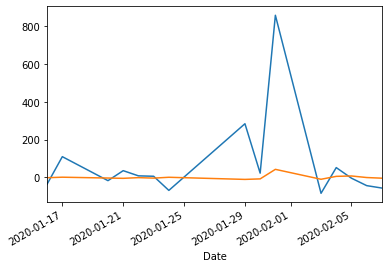

In [0]:
def volact(stock):
    f1y = pdr.get_data_yahoo(stock, start=start3m, end=end)
    del f1y["High"]
    del f1y["Low"]
    del f1y["Open"]
    # del f1y["Close"]
    del f1y["Adj Close"]
    meanclo = f1y["Close"].mean()
    meanvol = f1y["Volume"].mean()
    # f1y["Volume roll20"] = f1y["Volume"].rolling(window=20).mean()
    # f1y["Volume roll50"] = f1y["Volume"].rolling(window=50).mean()
    f1y["Close chg% mean"] = f1y["Close"].apply(lambda x: round(((x-meanclo)/meanclo)*100,2))
    f1y["Volume chg% mean"] = f1y["Volume"].pct_change()#.apply(lambda x: round(((x-meanvol)/meanvol)*100,2))
    listvol = []
    listclo = []
    for i in range(0,len(f1y)):
        listclo.append(round(((f1y["Close"][i]-f1y["Close"][i-1])/f1y["Close"][i-1])*100,2))
        listvol.append(round(((f1y["Volume"][i]-f1y["Volume"][i-1])/f1y["Volume"][i-1])*100,2))
    f1y["Close %chg from ytd"] = listclo
    f1y["Volume %chg from ytd"] = listvol
    f1y["Close 20 Day rollover %chg ytd"] = abs(f1y["Close %chg from ytd"]).rolling(window=20).mean()
    f1y["Volume 20 Day rollover %chg ytd"] = abs(f1y["Volume %chg from ytd"]).rolling(window=20).mean()
    pd.set_option('display.max_columns', 30)
    f1y["Volume %chg from ytd"][-15:].plot()
    f1y["Close %chg from ytd"][-15:].plot()
    return f1y[-15:]
volact("3313.HK")

In [0]:
def AG (stock, dayss):
    stt = datetime.datetime.now() - datetime.timedelta(days=dayss)
    f1y = pdr.get_data_yahoo(stock, start=stt, end=end)
    listreturns = []
    for i in range(len(f1y)):
        try:
            listreturns.append(((f1y["Close"][i+1]-f1y["Close"][i])/f1y["Close"][i])*100)
        except:
            continue
    average_growth = sum(listreturns)/len(listreturns)
    return(average_growth)

def rally(stock):
    f1m = pdr.get_data_yahoo(stock, start=start1m, end=end)
    f14d = pdr.get_data_yahoo(stock, start=start14d, end=end)
    f7d = pdr.get_data_yahoo(stock, start=start7d, end=end)
    print(stock)
    listreturns1m = []
    for i in range(len(f1m)):
        try:
            listreturns1m.append(round(((f1m["Close"][i+1]-f1m["Close"][i])/f1m["Close"][i])*100,2))
        except:
            continue
    average_growth1m = sum(listreturns1m)/len(listreturns1m)
    pos1m = []
    neg1m = []
    for y in listreturns1m:
        if y>0:
            pos1m.append(y)
        else:
            neg1m.append(y)
    nega1m= len(neg1m)/len(listreturns1m)
    negat1m = str(len(neg1m)) +"/"+ str(len(listreturns1m))
    posi1m= len(pos1m)/len(listreturns1m)
    posit1m = str(len(pos1m)) +"/"+ str(len(listreturns1m))
    print("number of positves 1m: ", posi1m, posit1m)
    print("number of negatives 1m: ", nega1m, negat1m)
    print("Average Growth per day 1m: ", round(average_growth1m,3))
    listreturns14d = []
    for i in range(len(f14d)):
        try:
            listreturns14d.append(round(((f14d["Close"][i+1]-f14d["Close"][i])/f14d["Close"][i])*100,2))
        except:
            continue
    average_growth14d = sum(listreturns14d)/len(listreturns14d)
    pos14d = []
    neg14d = []
    for y in listreturns14d:
        if y>0:
            pos14d.append(y)
        else:
            neg14d.append(y)
    nega14d= len(neg14d)/len(listreturns14d)
    negat14d = str(len(neg14d)) +"/"+ str(len(listreturns14d))
    posi14d= len(pos14d)/len(listreturns14d)
    posit14d = str(len(pos14d)) +"/"+ str(len(listreturns14d))
    print("number of positves 14d: ", posi14d, posit14d)
    print("number of negatives 14d: ", nega14d, negat14d)
    print("Average Growth per day 14d: ", round(average_growth14d,3))
    listreturns7d = []
    for i in range(len(f7d)):
        try:
            listreturns7d.append(((f7d["Close"][i+1]-f7d["Close"][i])/f7d["Close"][i])*100)
        except:
            continue
    average_growth7d = sum(listreturns7d)/len(listreturns7d)
    pos7d = []
    neg7d = []
    for y in listreturns7d:
        if y>0:
            pos7d.append(y)
        else:
            neg7d.append(y)
    nega7d= len(neg7d)/len(listreturns7d)
    negat7d = str(len(neg7d)) +"/"+ str(len(listreturns7d))
    posi7d= len(pos7d)/len(listreturns7d)
    posit7d = str(len(pos7d)) +"/"+ str(len(listreturns7d))
    
    print("number of positves 7d: ", posi7d, posit7d)
    print("number of negatives 7d: ", nega7d, negat7d)
    print("Average Growth per day 7d: ", round(average_growth7d,3))
    print("Latest Close Price: ", f7d["Close"][len(f7d)-1])
    print("Past 1m Returns: ", listreturns1m[:len(listreturns1m)-10] ,listreturns1m[-10:])
    print("Volume: ")#f7d["Volume"][0],f7d["Volume"][1],f7d["Volume"][2],f7d["Volume"][3],f7d["Volume"][4]
    for i in range(0,10):
      try:
        print(i, " ", f7d["Volume"][i])
      except:
        pass
    
def close (stock):
    f7d = pdr.get_data_yahoo(stock, start=start7d, end=end)["Close"]
    s = len(f7d)-1
    return float(f7d[s])
def posrally (i, CP, vola, ag14):
    if close(i) > CP and abs(AG(i,7)-AG(i,14)) < vola and AG(i,14) > ag14:
        return(rally(i))
def negrally(i,UPR,LWR, vola, ag14):
    if close(i) < UPR and close(i) > LWR and abs(AG(i,7)-AG(i,14)) < vola and AG(i,14) < -1*ag14:
        return(rally(i))
def miscrally(i,LWR, vola, ag14):
    if (close(i) > LWR and abs(AG(i,7)-AG(i,14)) < vola and AG(i,14) < -1*ag14) or (close(i) > LWR and abs(AG(i,7)-AG(i,14)) < vola and AG(i,14) > ag14):
        return(rally(i))

In [0]:
print("All Time High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in ath():
    try:
        posrally(i, 10, 1.25, 2)
    except:
        continue
print("52 Week High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in fth():
    try:
        posrally(i, 10, 1.25, 2)
    except:
        continue
print("Gainers")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in gai():
    try:
        posrally(i, 10, 1.25, 2)
    except:
        continue
print("1 Month High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in mth():
    try:
        posrally(i, 10, 1.25, 2)
    except:
        continue

All Time High
------------------------------------------------------------------------------------------------------------------------------------------------------------
6185.HK
number of positves 1m:  0.7368421052631579 14/19
number of negatives 1m:  0.2631578947368421 5/19
Average Growth per day 1m:  1.482
number of positves 14d:  0.8571428571428571 6/7
number of negatives 14d:  0.14285714285714285 1/7
Average Growth per day 14d:  2.046
number of positves 7d:  1.0 4/4
number of negatives 7d:  0.0 0/4
Average Growth per day 7d:  2.302
Latest Close Price:  75.5
Past 1m Returns:  [0.52, 3.79, -2.91, -1.71, 5.4, 0.91, 4.01, -1.65, 4.0] [0.31, 3.53, -2.37, -4.93, 0.96, 9.09, 6.23, 0.41, 1.49, 1.07]
Volume: 
0   834584
1   871222
2   932400
3   524800
4   756400
52 Week High
------------------------------------------------------------------------------------------------------------------------------------------------------------
6185.HK
number of positves 1m:  0.7368421052631579 14/19
num

In [0]:
print("All Time High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in ath():
    try:
        posrally(i, 5, 1.25, 2)
    except:
        continue
print("52 Week High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in fth():
    try:
        posrally(i, 5, 1.25, 2)
    except:
        continue
print("Gainers")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in gai():
    try:
        posrally(i, 5, 1.25, 2)
    except:
        continue
print("1 Month High")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in mth():
    try:
        posrally(i, 5, 1.25, 2)
    except:
        continue

All Time High
------------------------------------------------------------------------------------------------------------------------------------------------------------
6185.HK
number of positves 1m:  0.7368421052631579 14/19
number of negatives 1m:  0.2631578947368421 5/19
Average Growth per day 1m:  1.482
number of positves 14d:  0.8571428571428571 6/7
number of negatives 14d:  0.14285714285714285 1/7
Average Growth per day 14d:  2.046
number of positves 7d:  1.0 4/4
number of negatives 7d:  0.0 0/4
Average Growth per day 7d:  2.302
Latest Close Price:  75.5
Past 1m Returns:  [0.52, 3.79, -2.91, -1.71, 5.4, 0.91, 4.01, -1.65, 4.0] [0.31, 3.53, -2.37, -4.93, 0.96, 9.09, 6.23, 0.41, 1.49, 1.07]
Volume: 
0   834584
1   871222
2   932400
3   524800
4   756400
52 Week High
------------------------------------------------------------------------------------------------------------------------------------------------------------
6185.HK
number of positves 1m:  0.7368421052631579 14/19
num

In [0]:
def TruRang (stock):
    histprices = pdr.get_data_yahoo(stock, start=start3m, end=end)
    HmL = []
    ytdCtH = []
    ytdCtL = []
    Hmyh = []
    ylml = []
    for i in range(1, len(histprices)):
        HmL.append(histprices["High"][i] - histprices["Low"][i])
        Hmyh.append(histprices["High"][i] - histprices["High"][i-1])
        ylml.append(histprices["Low"][i-1] - histprices["Low"][i])
        ytdCtH.append(abs(histprices["Close"][i-1] - histprices["High"][i]))
        ytdCtL.append(abs(histprices["Close"][i-1] - histprices["Low"][i]))
    HmL.insert(0,None)
    ytdCtH.insert(0,None)
    ytdCtL.insert(0,None)
    Hmyh.insert(0,None)
    ylml.insert(0,None)
    histprices["Today's High Minus Today's Low"] = HmL
    histprices["yesterday's close to today's high"] = ytdCtH
    histprices["yesterday's close to today's low"] = ytdCtL
    TR=[]
    for i in range(len(histprices)):
        try:
            TR.append(max(histprices["Today's High Minus Today's Low"][i],histprices["yesterday's close to today's high"][i],histprices["yesterday's close to today's low"][i]))
        except:
            TR.append(None)
    histprices["True Range"] = TR
    del histprices["Today's High Minus Today's Low"] 
    del histprices["yesterday's close to today's high"] 
    del histprices["yesterday's close to today's low"] 
    del histprices["Adj Close"]

    histprices["Upmove"] = Hmyh #Today's High Minus Yesterday's High
    histprices["Downmove"] = ylml #Yesterday's Low Minus Today's Low
    PDM = []
    NDM = []
    for i in range(len(histprices)):
        if histprices["Upmove"][i] > histprices["Downmove"][i] and histprices["Upmove"][i] > 0:
            PDM.append(histprices["Upmove"][i])
        else: 
            PDM.append (0)
        if histprices["Downmove"][i] > histprices["Upmove"][i] and histprices["Downmove"][i] > 0:
            NDM.append(histprices["Downmove"][i])
        else: 
            NDM.append (0)
    histprices["Positive Directional Movement"] = PDM
    histprices["Negative Directional Movement"] = NDM
    expPDM = histprices["Positive Directional Movement"].ewm(span=14, adjust=False).mean()
    expNDM = histprices["Negative Directional Movement"].ewm(span=14, adjust=False).mean()
    expATR = histprices["True Range"].ewm(span=14, adjust=False).mean()
    histprices["14 EMA PDM"] = expPDM
    histprices["14 EMA NDM"] = expNDM
    histprices["14 EMA ATR"] = expATR
    PDI = []
    NDI = []
    for xx in range (len(histprices)):
        PDI.append(100 * (histprices["14 EMA PDM"][xx]/histprices["14 EMA ATR"][xx]))
        NDI.append(100 * (histprices["14 EMA NDM"][xx]/histprices["14 EMA ATR"][xx]))
    histprices["PDI"] = PDI
    histprices["NDI"] = NDI
    DX = []
    for xxx in range (len(histprices)):
        DX.append(100*((abs(histprices["PDI"][xxx]-histprices["NDI"][xxx]))/(histprices["PDI"][xxx]+histprices["NDI"][xxx])))
    histprices["DX"] = DX
    histprices["ADX"] = histprices["DX"].ewm(span=14, adjust=False).mean()
    rolling_mean = histprices["Close"].rolling(window=5).mean()
    histprices["20 SMA"] = rolling_mean
    
    # Graphing
    plt.style.use('fivethirtyeight')
    fig, axs = plt.subplots(2, 1, sharex=True, figsize = (16,12))
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0)
    axs[1].plot(histprices["ADX"],linewidth=0.75, label = "ADX")
    axs[1].plot(histprices["PDI"],linewidth=0.75, label = "PDI")
    axs[1].plot(histprices["NDI"],linewidth=0.75, label = "NDI")
    axs[0].plot(histprices["Close"],linewidth=0.75, label = "Close")
    axs[0].plot(histprices["20 SMA"],linewidth=0.75, label = "Close 20 SMA")
    axs[0].set_title('Close')
    axs[1].set_title('ADX')
    axs[1].axhline(y=20,linewidth=0.5, color='k')
    axs[1].axhline(y=25,linewidth=0.5, color='k')
    axs[0].set_ylabel('Price (HKD)')
    axs[1].set_ylabel('Trend Strength')
    axs[1].set_xlabel('Date')
    fig.tight_layout()
    axs[0].legend()
    axs[1].legend()
    
    plt.show()
#     return(histprices)

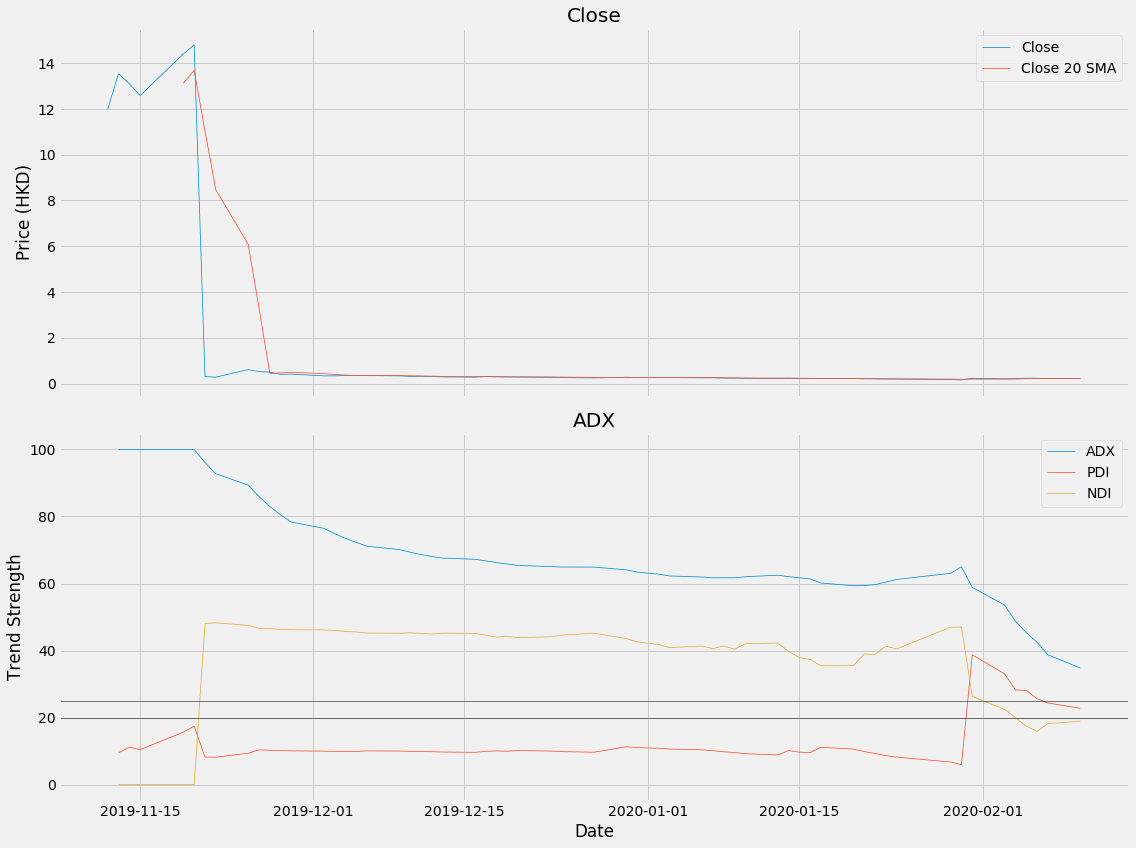

In [5]:
# The ADX identifies a strong trend when the ADX is over 25 and a weak trend when the ADX is below 20.
# Crossovers of the -DI and +DI lines can be used to generate trade signals. For example, if the +DI line 
# crosses above the -DI line and the ADX is above 20, or ideally above 25, then that is a potential signal to buy.
# If the -DI crosses above the +DI, and ADX is above 20 or 25, then that is an opportunity to enter a potential short trade.
# Crosses can also be used to exit current trades. For example, if long, exit when the -DI crosses above the +DI.
# When ADX is below 20 the indicator is signaling that the price is trendless, and therefore may not be an ideal time 
# to enter a trade.
TruRang("3313.HK")

In [0]:
# Make function for calls to Yahoo Finance
def get_adj_close(ticker, start, end):
    start = start
    end = end
    info = pdr.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
    return pd.DataFrame(info)
def simpleBB(stock):
    # Get Adjusted Closing Prices for HK stocks
    hk1 = get_adj_close(stock, start1y, end)

    # Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
    hk1['30 Day MA'] = hk1['Adj Close'].rolling(window=20).mean()
    hk1['30 Day STD'] = hk1['Adj Close'].rolling(window=20).std()
    hk1['Upper Band'] = hk1['30 Day MA'] + (hk1['30 Day STD'] * 2)
    hk1['Lower Band'] = hk1['30 Day MA'] - (hk1['30 Day STD'] * 2)

    # Simple 30 Day Bollinger Band for Facebook (2016-2017)
    hk1[['Adj Close', '30 Day MA', 'Upper Band', 'Lower Band']].plot(figsize=(16,4),linewidth=0.75)
    plt.title('30 Day Bollinger Band for '  + stock)
    plt.ylabel('Price (HKD)')
    plt.show();
def shadedBB(stock):
    # Get Adjusted Closing Prices for HK stocks
    hk1 = get_adj_close(stock, start1y, end)
    # Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
    hk1['30 Day MA'] = hk1['Adj Close'].rolling(window=20).mean()
    hk1['30 Day STD'] = hk1['Adj Close'].rolling(window=20).std()
    hk1['Upper Band'] = hk1['30 Day MA'] + (hk1['30 Day STD'] * 2)
    hk1['Lower Band'] = hk1['30 Day MA'] - (hk1['30 Day STD'] * 2)
    # set style, empty figure and axes
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    # Get index values for the X axis for facebook DataFrame
    x_axis = hk1.index.get_level_values(0)
    # Plot shaded 21 Day Bollinger Band for Facebook
    ax.fill_between(x_axis, hk1['Upper Band'], hk1['Lower Band'], color='grey')
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(x_axis, hk1['Adj Close'],linewidth=0.75, color='blue', lw=2)
    ax.plot(x_axis, hk1['30 Day MA'],linewidth=0.75, color='black', lw=2)
    # Set Title & Show the Image
    ax.set_title('30 Day Bollinger Band For ' + stock)
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price (HKD)')
    ax.legend()
    plt.show();
# https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a 
# https://pypi.org/project/stockstats/
from stockstats import StockDataFrame as sdf
def macd(stock):
    df = pdr.get_data_yahoo(stock, start=start1y, end=end)
    stock = sdf.retype(df)
    dates = stock.index.tolist()
    stock['Dates'] = dates
    signal = stock['macds']        # Your signal line
    macd = stock['macd'] 
    plt.figure(figsize=(16,4))
    plt.plot(signal)
    plt.plot(macd)
    plt.ylabel('Points')
    plt.xlabel('Days')
    plt.axhline(y=0,color='#adcdff')
    plt.legend(['macd','macds'], loc='upper left')
    plt.show()

3313


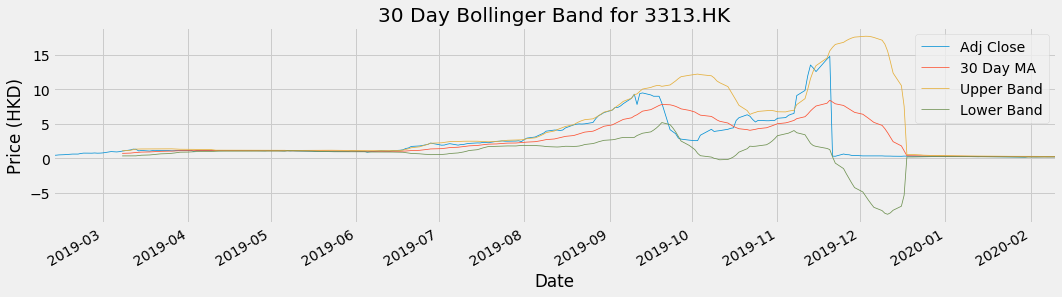

None


No handles with labels found to put in legend.


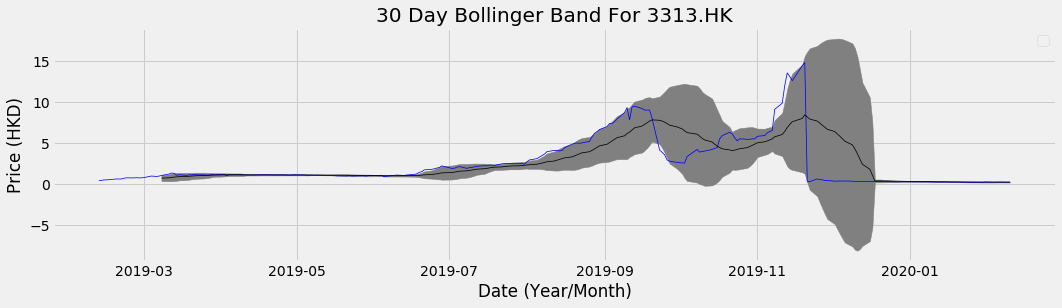

None


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


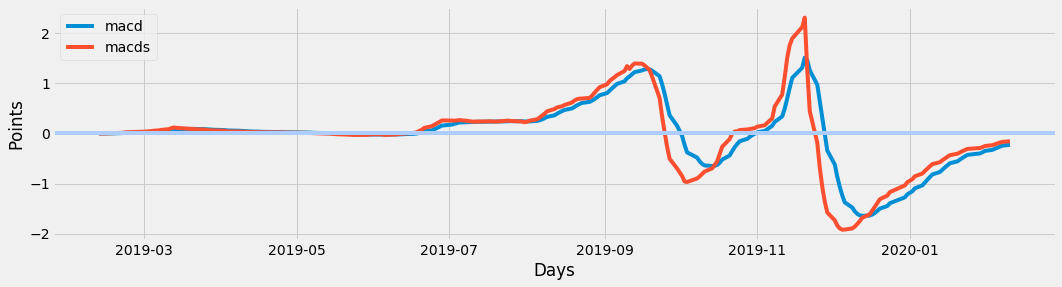

None


In [7]:
stoc = str(input())
stock = stoc +'.HK'
print(simpleBB(stock))
print(shadedBB(stock))
print(macd(stock))